<div class="alert">
<center>
 Problème Inverse: SAR 


Pierrick Bournez Mathis Weller


Un rapport annexe est fourni avec les analyses théoriques 

# 0. définitions des hyperparamètres

In [90]:
import numpy as np

In [91]:
z = 0
N = 64
w0 = 2 * np.pi
B = np.pi / 4
zref = np.array([5, 100, 0])
a = 20
xn = np.zeros((N, 3))
# print(xn)
for n in range(N):
    xn[n][0] = -a / 2 + a * (n - 1) / (N - 1)
M = 64

# discretize the frequency band
f0 = w0 - B
f1 = w0 + B
fband = np.linspace(f0, f1, M)

In [92]:
import numpy as np

In [ ]:
# 1 La green function  on approxime par la partie1


class Green:
    def __init__(self):

        pass

    def __call__(self, w, x, y):
        return (1 / (4 * np.pi * np.linalg.norm(x - y))) * np.exp(
            1j * w * np.linalg.norm(x - y)
        )
f = Green()
f(1, 5, 6)

(0.04299589137143181+0.06696213335029096j)

In [101]:
# On introduit ici R_n
rho_ref = 1


class R_n:
    # correspond à Rnchapeau
    def __init__(self, rho_ref, f0, f1, zref, xn):
        self.rho_ref = rho_ref
        self.f0 = f0
        self.f1 = f1
        self.xn = xn
        self.zref = zref
        self.green = Green()

    def __call__(self, n, w):
        def rn(n, w):
            # assert w in fband
            if w < self.f0 or w > self.f1:
                return 0
            return self.rho_ref * self.green(w, self.xn[n], zref) ** 2

        return rn(n, w)


R_n(rho_ref, f0, f1, zref, xn)(0, w0)
# R_n(rho_ref,f0,f1,zref_test,xn_test)(0,w0)

(-3.070424805386075e-07+5.371818946225972e-07j)

## créons  l'imaging Function

In [98]:
Tn = 1

In [103]:
class Imagingfun:
    def __init__(self, xn, rho_ref, f0, f1, zref, fband):
        self.xn = xn
        self.rho_ref = rho_ref
        self.f0 = f0
        self.f1 = f1
        self.zref = zref
        self.rn = R_n(rho_ref=rho_ref, f0=f0, f1=f1, zref=zref, xn=xn)
        self.fband = fband
        self.M = len(fband)
        self.N = len(xn)
        self.dw = (f1 - f0) / self.M
        self.green = Green()
        self.second_term = self.constructR()

    def constructR(self):
        result = np.zeros((self.N, self.M), dtype=complex)
        for n in range(self.N):
            for k in range(self.M):
                w = self.fband[k]
                result[n, k] = self.rn(n, w)  # +create_noise(1,noise)
        return result

    def R(self, w, x, x_n):
        if w < self.f0 or w > self.f1:
            print("out of f_n for w", w)
            return 0
        # add fn
        fn = np.exp(-2j * Tn * w)
        return self.green(w, x_n, x) ** 2 * fn

    def __call__(self, x):
        # we compute  the integrale
        Somme = 0
        for n in range(self.N):
            Somme_n = 0
            for k in range(self.M):
                w = self.fband[k]
                first_term = np.conjugate(self.R(w=w, x=x, x_n=self.xn[n]))
                # second_term=self.rn(n,w)
                second_term = self.second_term[n, k]
                Somme_n += first_term * second_term * self.dw
            Somme += Somme_n
        return np.abs(Somme)


I_fun = Imagingfun(xn=xn, rho_ref=rho_ref, f0=f0, f1=f1, zref=zref, fband=fband)

I_fun(zref)

2.494862043068491e-11

In [104]:
I_fun(np.array([5,101.09,0]))

3.88048037033807e-11

# Cas 1 : Pas de bruit
On va plot l'imaging fonction en absence de bruit puis  afficher les résultats

In [105]:
l_inf_x=-2
l_sup_x=12

l_inf_y=90
l_sup_y=110


res = 10
x = np.meshgrid(np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res))

In [106]:


import matplotlib.pyplot as plt

# plot the imaging function
def compute_maxIcoords(I_grid, zref,x=x):
    max_I_index = np.unravel_index(np.argmax(I_grid, axis=None), I_grid.shape)
    max_I_coords = x[0][max_I_index], x[1][max_I_index]
    return max_I_coords

def compute_grid(l_inf_x, l_sup_x, l_inf_y, l_sup_y, res, zref, I_fun):
    x = np.meshgrid(
        np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res)
    )
    # compute the imaging function on the grid
    I_grid = np.zeros((res, res))
    for i in range(res):
        for j in range(res):
            I_grid[i, j] = I_fun(np.array([x[0][i, j], x[1][i, j], zref[2]]))
    max_I_coords=compute_maxIcoords(I_grid,zref,x=x)
    return I_grid,max_I_coords
def plot_result(I_grid, zref, max_I_coords,
                l_inf_x, l_sup_x, l_inf_y, l_sup_y, title="Imaging function with no noise"):

    res_x, res_y = I_grid.shape
    dx = (l_sup_x - l_inf_x) / (res_x - 1)
    dy = (l_sup_y - l_inf_y) / (res_y - 1)

    extent = (l_inf_x - dx/2, l_sup_x + dx/2, l_inf_y - dy/2, l_sup_y + dy/2)

    fig = plt.figure()
    plt.imshow(I_grid, extent=extent, origin="lower", aspect="auto")
    
    # Plot the maximum found
    plt.scatter(max_I_coords[0], max_I_coords[1], s=100, c="green", label="Maximum found", marker="x")
    plt.scatter(zref[0], zref[1], s=100, c="red", label="zref", marker="x")

    plt.colorbar()
    plt.title(title)
    plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))

    print(
        "Difference between the ground truth and the maxima:",
        np.linalg.norm(np.array(max_I_coords) - zref[:2]),
    )
    plt.tight_layout()
    plt.show()

    return max_I_coords

Dans un premier temps avec peu de résolution

Difference between the ground truth and the maxima: 0.0


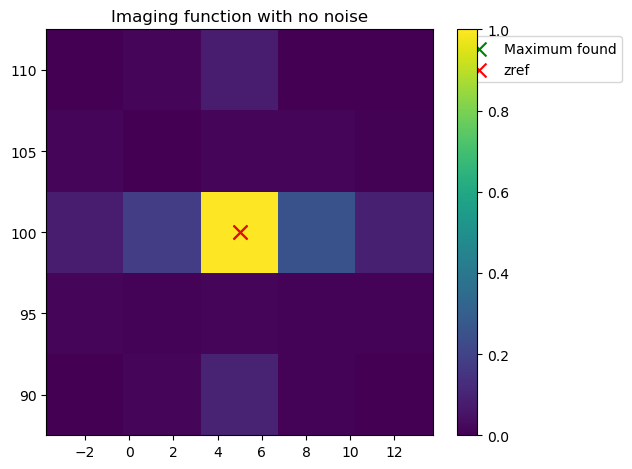

(5.0, 100.0)

In [82]:
res = 5
x = np.meshgrid(np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res))
I_grid,max_I_coords = compute_grid(l_inf_x, l_sup_x, l_inf_y, l_sup_y, res, zref, I_fun)
plot_result(I_grid, zref, max_I_coords,l_inf_x=l_inf_x, l_sup_x=l_sup_x, l_inf_y=l_inf_y, l_sup_y=l_sup_y)

On augmente la résolution

Difference between the ground truth and the maxima: 0.9090909090909065


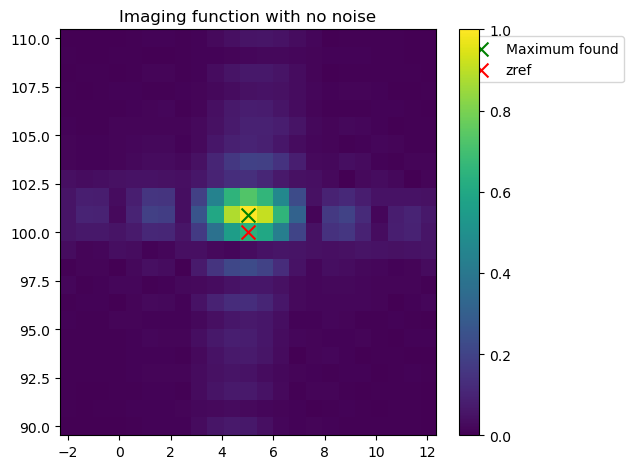

(5.0, 100.9090909090909)

In [83]:
res = 23
x = np.meshgrid(np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res))
I_grid,max_I_coords = compute_grid(l_inf_x, l_sup_x, l_inf_y, l_sup_y, res, zref, I_fun)
plot_result(I_grid, zref, max_I_coords,l_inf_x=l_inf_x,l_sup_x=l_sup_x,l_inf_y=l_inf_y,l_sup_y=l_sup_y)

Difference between the ground truth and the maxima: 1.0909090909090935


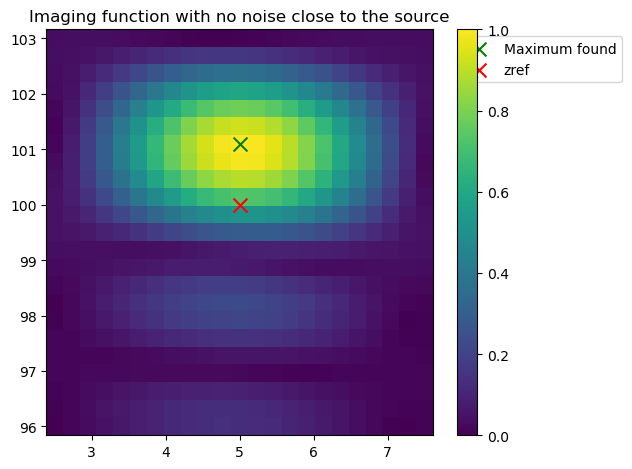

(5.0, 101.0909090909091)

In [85]:
res = 23
l_inf_close_x=2.5
l_sup_close_x=7.5
l_inf_close_y=96
l_sup_close_y=103
x = np.meshgrid(np.linspace(l_inf_close_x, l_sup_close_x, res), np.linspace(l_inf_close_y, l_sup_close_y, res))
I_grid,max_I_coords = compute_grid(l_inf_close_x, l_sup_close_x, l_inf_close_y, l_sup_close_y, res, zref, I_fun)
plot_result(I_grid, zref, max_I_coords,l_inf_y=l_inf_close_y,l_sup_y=l_sup_close_y,l_inf_x=l_inf_close_x,l_sup_x=l_sup_close_x,title="Imaging function with no noise close to the source")


Le maximum théorique et celui de la fonction d'imagerie sont très proches, mais ne coïncident pas en raison des erreurs induites par les schémas d'intégration.
( la différence d'intégrale dépend du calcule de I et non des plots )


# Cas 2 : Analyse de stabilité

On analyse dans un premier temps la stabilité par un bruit additif puis par des positions d'emetteurs/récepteurs incertains.

##  Premier cas: données corrompus par un bruit additif

### Définitions des fonctions
On définie ici les fonctions utiles à cette partie 

In [107]:
z = 0
N = 64
w0 = 2 * np.pi
B = np.pi / 4
zref = np.array([5, 100, 0])
a = 20
xn = np.zeros((N, 3))
# print(xn)
for n in range(N):
    xn[n][0] = -a / 2 + a * (n - 1) / (N - 1)
M = 64

# discretize the frequency band
f0 = w0 - B
f1 = w0 + B
fband = np.linspace(f0, f1, M)

In [108]:
noise = 0.01

In [109]:
# create an complex zero mean gaussian noise
def create_noise(n, sigma):
    z = np.random.normal(loc=0, scale=np.sqrt(2) / 2, size=(n, 2)).view(np.complex128)
    return z * sigma

On crée la fonction d'imagine avec du bruit sur les données

In [110]:
class Imagingfun_antennaNoise(Imagingfun):
    def __init__(self, xn, rho_ref, f0, f1, zref, fband, noise):
        self.noise = noise
        super().__init__(xn=xn, rho_ref=rho_ref, f0=f0, f1=f1, zref=zref, fband=fband)

    def constructR(self):
        result = np.zeros((self.N, self.M), dtype=complex)
        for n in range(self.N):
            for k in range(self.M):
                w = self.fband[k]
                result[n, k] = self.rn(n, w) + create_noise(1, self.noise).squeeze()
        return result

    def R(self, w, x, x_n):
        if w < self.f0 or w > self.f1:
            print("out of f_n for w", w)
            return 0
        # add fn
        fn = np.exp(-2j * Tn * w)
        return self.green(w, x_n, x) ** 2 * fn

    def __call__(self, x):
        # we compute  the integrale
        Somme = 0
        for n in range(self.N):
            Somme_n = 0
            for k in range(self.M):
                w = self.fband[k]
                first_term = np.conjugate(self.R(w=w, x=x, x_n=self.xn[n]))
                second_term = self.second_term[n, k]
                Somme_n += first_term * second_term * self.dw
            Somme += Somme_n
        return np.abs(Somme)


I_fun = Imagingfun_antennaNoise(
    xn=xn, rho_ref=rho_ref, f0=f0, f1=f1, zref=zref, fband=fband, noise=1
)


I_fun(zref)

4.7314233107119984e-07

In [111]:
res = 25
noise = 1e-7

In [ ]:
import matplotlib.pyplot as plt


def plot_noise(noise, max_I_coords, zref,xlog=True):
    fig = plt.figure()
    res = []
    for elem in max_I_coords:
        res.append(np.linalg.norm(elem - zref[:2]))
    # plot in log scale
    plt.plot(noise, res)

    plt.xlabel("Noise")
    if xlog:
        plt.xscale("log")
    plt.ylabel("Difference between the ground truth and the maxima")
    plt.title("Difference between the ground truth and the maxima")
    plt.legend()
    return

def plot_noise_xy(noise,max_I_coords,zref,xlog=True):
    fig = plt.figure()
    res = []
    for elem in max_I_coords:
        print("res", res)
        res.append(np.linalg.norm(elem[0] - zref[0]))
    # plot in log scale
    plt.plot(noise, res)
    plt.xlabel("Noise")
    if xlog:
        plt.xscale("log")
    plt.ylabel("Difference between the ground truth and the maxima")
    plt.title("Difference between the ground truth and the maxima along the x axis ")
    plt.legend()
    plt.show() 

    fig= plt.figure()
    res = []
    for elem in max_I_coords:
        print("res", res)
        res.append(np.linalg.norm(elem[1] - zref[1]))
    # plot in log scale
    plt.plot(noise, res)
    plt.xlabel("Noise")
    if xlog:
        plt.xscale("log")
    plt.ylabel("Difference between the ground truth and the maxima")
    plt.title("Difference between the ground truth and the maxima along the y axis ")
    plt.legend()
    plt.show()
    return

In [119]:
x = np.meshgrid(np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res))
import matplotlib.pyplot as plt

noisel = [10**-k for k in range(1, 4)]


def compute_noise_data(noisel, ntry=4):
    max_I_coordsl = []

    for noise in noisel:
        max_I_coords_average = []
        for i in range(ntry):
            I_fun = Imagingfun_antennaNoise(
                xn=xn,
                rho_ref=rho_ref,
                f0=f0,
                f1=f1,
                zref=zref,
                fband=fband,
                noise=noise,
            )
            I_grid,max_I_coords = compute_grid(
                l_inf_x, l_sup_x, l_inf_y, l_sup_y, res, zref, I_fun=I_fun
            )

            max_I_coords_average.append(max_I_coords)

            if i == 1:
                plot_result(
                    I_grid,
                    zref,
                    max_I_coords,
                    title="Imaging function with noise of level {}".format(noise),
                    l_inf_x=l_inf_x,
                    l_sup_x=l_sup_x,
                    l_inf_y=l_inf_y,
                    l_sup_y=l_sup_y,
                )

        max_I_coords = np.mean(max_I_coords_average, axis=0)
        # plot it case
        # average the max_I_coords
        max_I_coordsl.append(max_I_coords)
    
    plot_noise(noisel, max_I_coordsl, zref,xlog=False)
    plot_noise_xy(noisel,max_I_coordsl,zref,xlog=False)

### Résultat 


On plot en fonction du bruit les maximum trouvé. Il s'agit ici d'une recherche pour différents type de bruit mais nous l'avons résumé dans le prochain graphique

In [ ]:
# x = np.meshgrid(np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res))
# import matplotlib.pyplot as plt

# max_I_coordsl = []
# noisel = [10**-k for k in range(2, 7)]
# compute_noise_data(noisel)

<!-- La différence de distance entre la vérité et le maximum augmente bien avec le bruit. Pour des valeurs de bruits trop élevés, la distance diminue mais cela est dû à la grid trop resérré -->
On observe que, pour nos valeurs numériques, la fonction d'imagerie atteint une valeur de l'ordre de \(10^{-7}\).  

Par conséquent, le graphique est focalisé sur une plage de bruit avoisinant cette valeur afin d'analyser plus précisément son impact.

Attention dans les graphiques qui suivent, les premiers graphiques correspondent aux **bruits les plus élevés**.


Difference between the ground truth and the maxima: 10.259142264341596


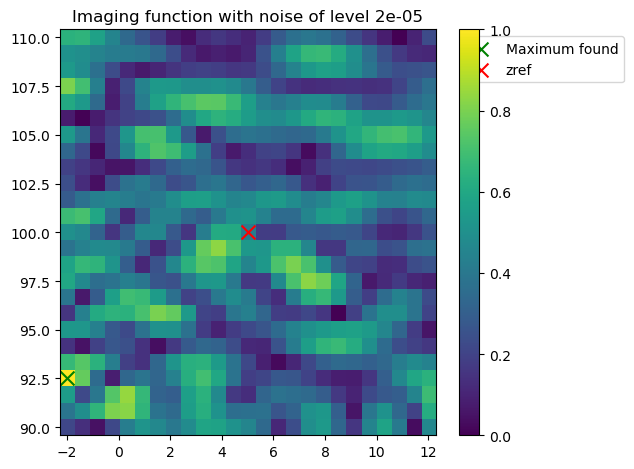

Difference between the ground truth and the maxima: 0.8333333333333286


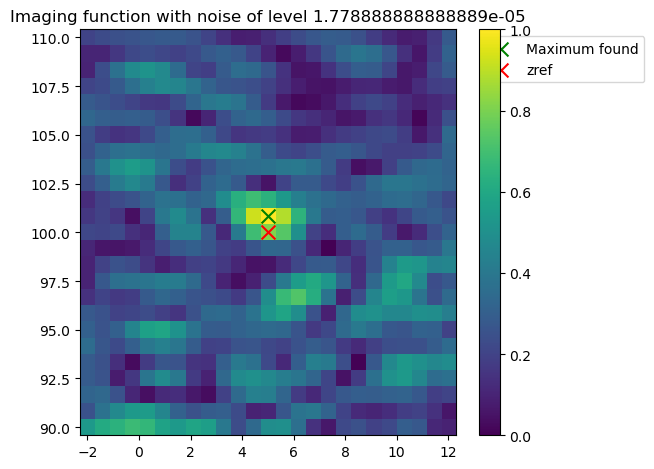

Difference between the ground truth and the maxima: 10.883218478209669


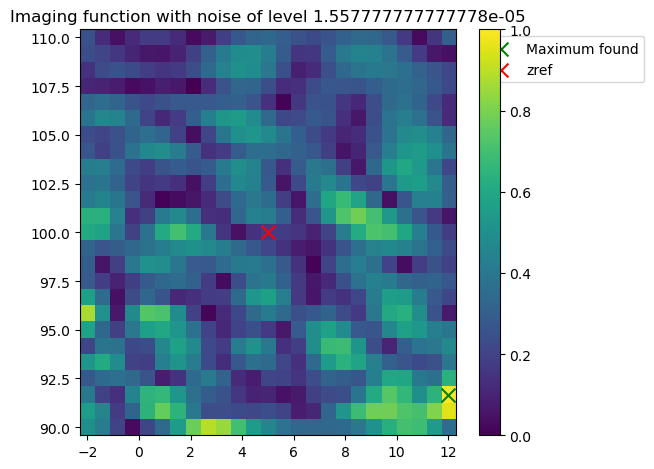

Difference between the ground truth and the maxima: 1.017212967977805


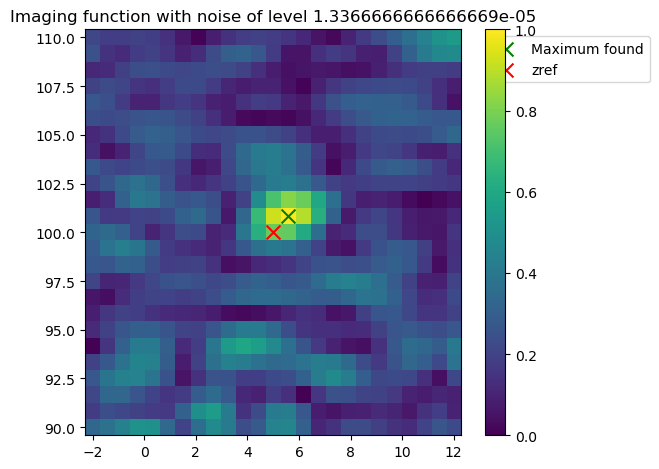

Difference between the ground truth and the maxima: 0.8333333333333286


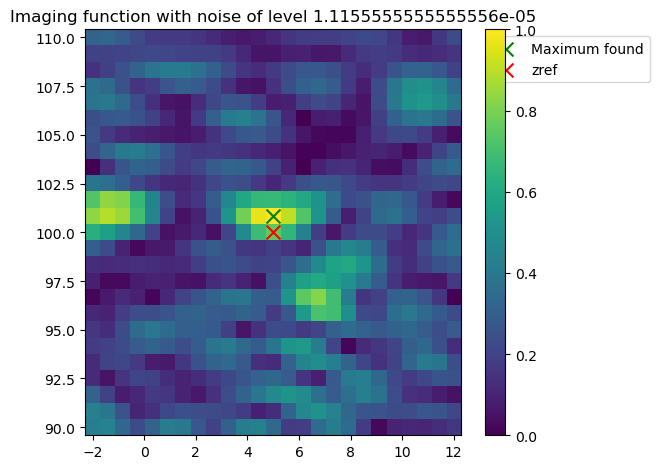

Difference between the ground truth and the maxima: 0.8333333333333286


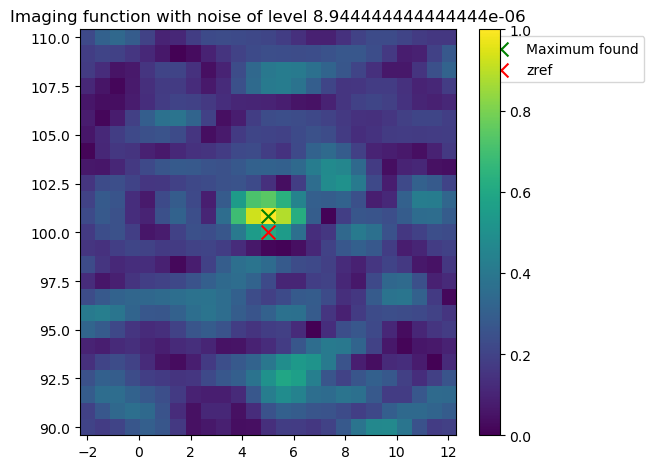

Difference between the ground truth and the maxima: 0.8333333333333286


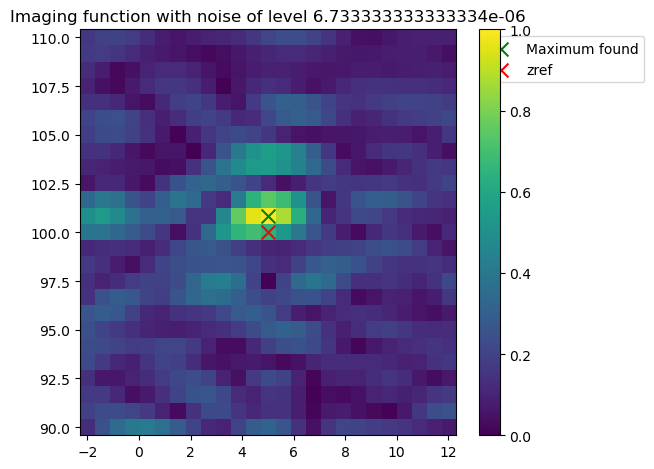

Difference between the ground truth and the maxima: 0.8333333333333286


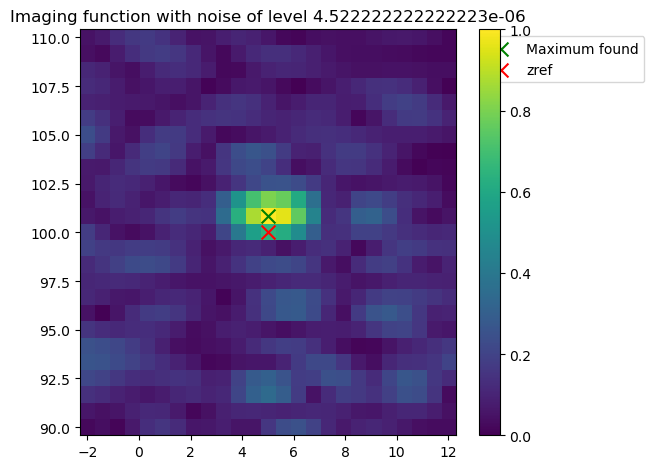

Difference between the ground truth and the maxima: 0.8333333333333286


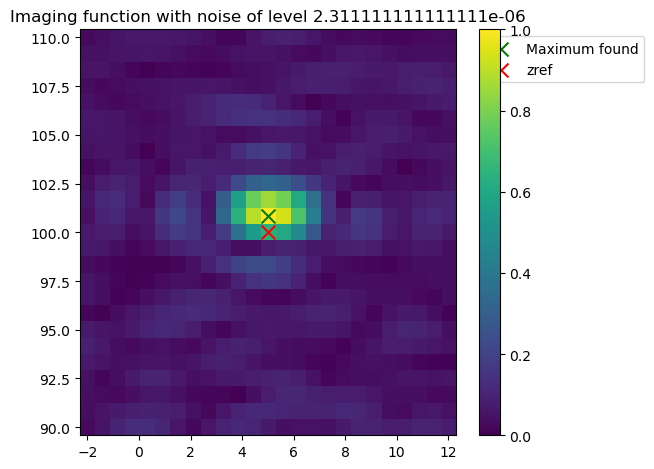

Difference between the ground truth and the maxima: 0.8333333333333286


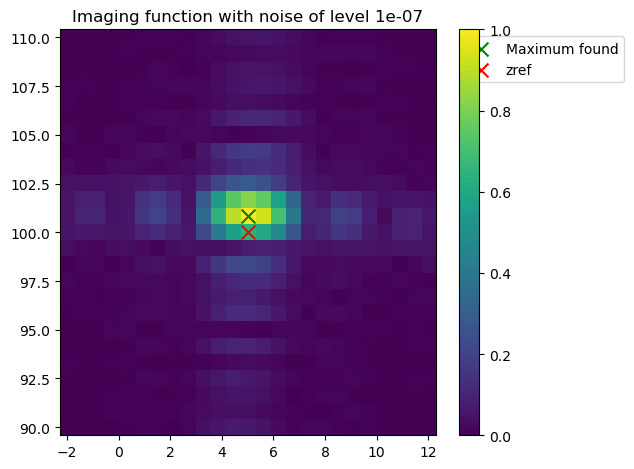

res []
res [4.519248954318754]
res [4.519248954318754, 2.06239477846076]
res [4.519248954318754, 2.06239477846076, 4.414504187586899]
res [4.519248954318754, 2.06239477846076, 4.414504187586899, 1.020833333333334]
res [4.519248954318754, 2.06239477846076, 4.414504187586899, 1.020833333333334, 0.8333333333333286]
res [4.519248954318754, 2.06239477846076, 4.414504187586899, 1.020833333333334, 0.8333333333333286, 0.8829008375173745]
res [4.519248954318754, 2.06239477846076, 4.414504187586899, 1.020833333333334, 0.8333333333333286, 0.8829008375173745, 0.8459975210102851]
res [4.519248954318754, 2.06239477846076, 4.414504187586899, 1.020833333333334, 0.8333333333333286, 0.8829008375173745, 0.8459975210102851, 0.8333333333333286]
res [4.519248954318754, 2.06239477846076, 4.414504187586899, 1.020833333333334, 0.8333333333333286, 0.8829008375173745, 0.8459975210102851, 0.8333333333333286, 0.8333333333333286]
res []
res [1.75]
res [1.75, 1.458333333333333]
res [1.75, 1.458333333333333, 1.458333

C:\Users\lix\AppData\Local\Temp\ipykernel_21748\3870641188.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\lix\AppData\Local\Temp\ipykernel_21748\3870641188.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


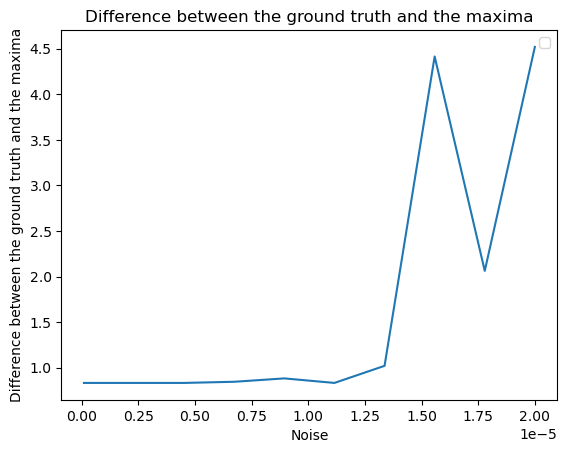

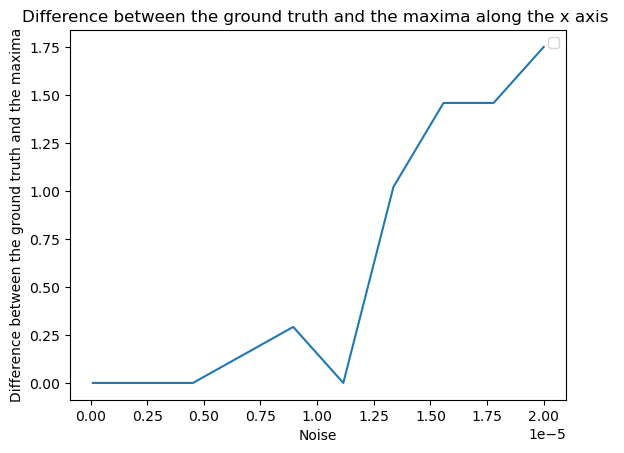

res []
res [4.166666666666671]
res [4.166666666666671, 1.4583333333333286]
res [4.166666666666671, 1.4583333333333286, 4.166666666666671]
res [4.166666666666671, 1.4583333333333286, 4.166666666666671, 0.0]
res [4.166666666666671, 1.4583333333333286, 4.166666666666671, 0.0, 0.8333333333333286]
res [4.166666666666671, 1.4583333333333286, 4.166666666666671, 0.0, 0.8333333333333286, 0.8333333333333286]
res [4.166666666666671, 1.4583333333333286, 4.166666666666671, 0.0, 0.8333333333333286, 0.8333333333333286, 0.8333333333333286]
res [4.166666666666671, 1.4583333333333286, 4.166666666666671, 0.0, 0.8333333333333286, 0.8333333333333286, 0.8333333333333286, 0.8333333333333286]
res [4.166666666666671, 1.4583333333333286, 4.166666666666671, 0.0, 0.8333333333333286, 0.8333333333333286, 0.8333333333333286, 0.8333333333333286, 0.8333333333333286]


C:\Users\lix\AppData\Local\Temp\ipykernel_21748\3870641188.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


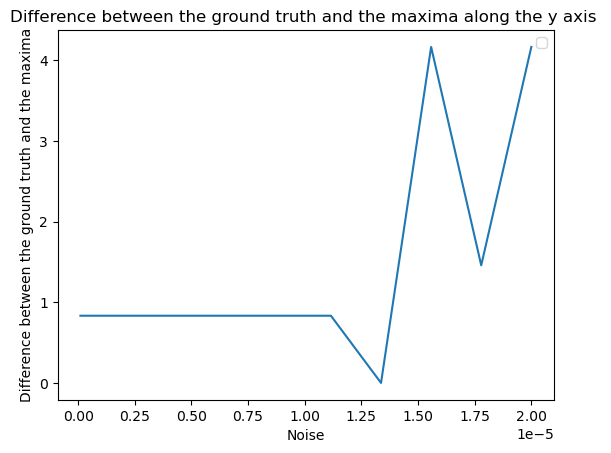

In [121]:
x = np.meshgrid(np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res))
import matplotlib.pyplot as plt

max_I_coordsl = []
noisel = np.linspace(2e-5, 1e-07, 10)
compute_noise_data(noisel)

On observe trois régimes distincts en fonction de l'intensité du bruit :

1. **Bruit élevé** : Lorsque l'amplitude du bruit dépasse celle du maximum de la fonction d'imagerie, plusieurs maxima locaux apparaissent, rendant indiscernable le maximum théorique.

2. **Bruit modéré** : Pour des niveaux de bruit intermédiaires, le maximum reste visible, mais le pic s'élargit, indiquant une dégradation de la résolution.

3. **Bruit faible** : En présence d'un bruit de faible intensité, la fonction d'imagerie se comporte de manière similaire à une situation sans bruit.

Ainsi, pour des niveaux de bruit élevés (de l'ordre de $(10^{-5}$), la position du maximum devient spatialement incertaine, ce qui explique les fortes variations observées dans le graphique.

## Dernier cas:  Dans ce cas, la position des récepteurs est inconnu

### Définitions des fonctions
On définie ici les fonctions utiles à cette partie 

In [ ]:
z = 0
N = 64
w0 = 2 * np.pi
B = np.pi / 4
zref = np.array([5, 100, 0])
a = 20
xn = np.zeros((N, 3))
# print(xn)
for n in range(N):
    xn[n][0] = -a / 2 + a * (n - 1) / (N - 1)
M = 64

# discretize the frequency band
f0 = w0 - B
f1 = w0 + B
fband = np.linspace(f0, f1, M)

In [ ]:
sigma = 1

On crée ici la fonction d'imagerie correspondante

In [ ]:
class Imagingfun_positionNoise(Imagingfun):
    def __init__(self, xn, rho_ref, f0, f1, zref, fband, noise):
        self.noise = noise
        super().__init__(xn=xn, rho_ref=rho_ref, f0=f0, f1=f1, zref=zref, fband=fband)
        xn_noised = xn + np.random.randn(xn.shape[0], xn.shape[1]) * self.noise
        self.rn = R_n(rho_ref=rho_ref, f0=f0, f1=f1, zref=zref, xn=xn_noised)
        self.second_term = self.constructR()

    def __call__(self, x):
        # we compute  the integrale
        Somme = 0
        for n in range(self.N):
            Somme_n = 0
            for k in range(self.M):
                w = self.fband[k]
                first_term = np.conjugate(self.R(w=w, x=x, x_n=self.xn[n]))
                second_term = self.second_term[n, k]
                Somme_n += first_term * second_term * self.dw
            Somme += Somme_n
        return np.abs(Somme)


I_fun = Imagingfun_positionNoise(
    xn=xn, rho_ref=rho_ref, f0=f0, f1=f1, zref=zref, fband=fband, noise=1
)


I_fun(zref)

4.26835438260721e-12

In [ ]:



def compute_noise_postion(noisel, ntry=4):
    max_I_coordsl = []
    for noise in noisel:
        max_I_coords_average = []
        for i in range(ntry):
            I_fun = Imagingfun_positionNoise(
                xn=xn,
                rho_ref=rho_ref,
                f0=f0,
                f1=f1,
                zref=zref,
                fband=fband,
                noise=noise,
            )

            I_grid,max_I_coords = compute_grid(
                l_inf_x, l_sup_x, l_inf_y, l_sup_y, res, zref, I_fun=I_fun
            )
            if i == 1:
                plot_result(
                    I_grid,
                    zref,
                    max_I_coords,
                    title="Imaging function with  Antenna noise of level {} ".format(
                        noise
                    ),
                )

            max_I_coords_average.append(max_I_coords)
        max_I_coords = np.mean(max_I_coords_average, axis=0)
        max_I_coordsl.append(max_I_coords)

    plot_noise(noisel, max_I_coordsl, zref)
    plot_noise_xy(noisel,max_I_coordsl,zref)
    return

### Résultat


Ici les capteurs sont dans une ligne de longueur 20 mètre. On va donc étudié pour des bruits variant entre 0.01 à 100 mètres. 


In [ ]:
# x = np.meshgrid(np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res))
# noisel = [10**k for k in range(-2, 2)]
# compute_noise_postion(noisel)

On se concentre maintenant au point d'inflexion, i.e pour un bruit  entre 0.01 mètre  et 0.9 mètres. 

Difference between the ground truth and the maxima: 0.6424502955649323


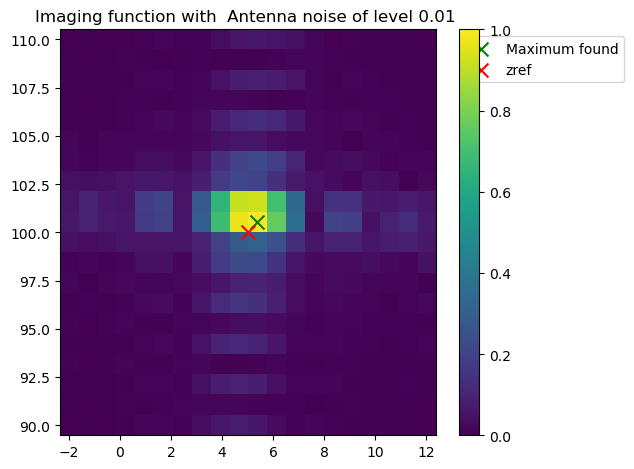

Difference between the ground truth and the maxima: 0.6424502955649323


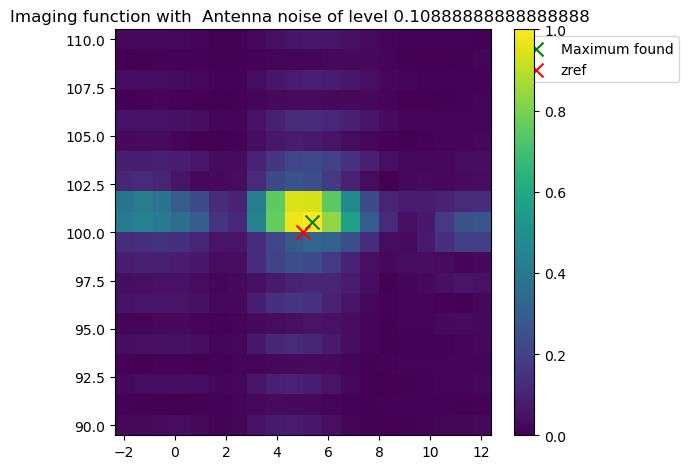

Difference between the ground truth and the maxima: 3.3573007229088554


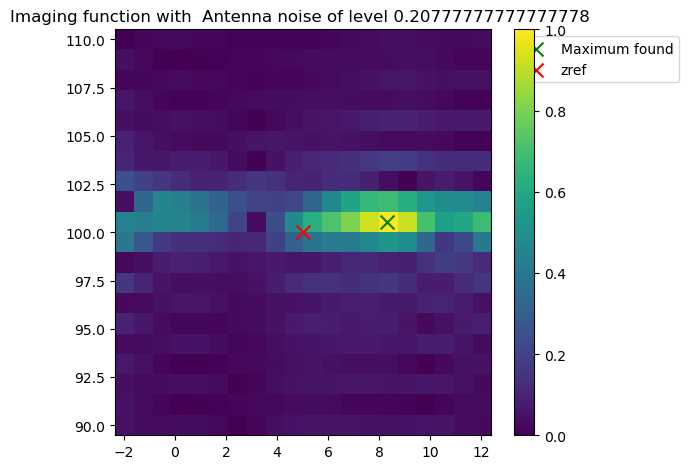

Difference between the ground truth and the maxima: 0.6424502955649323


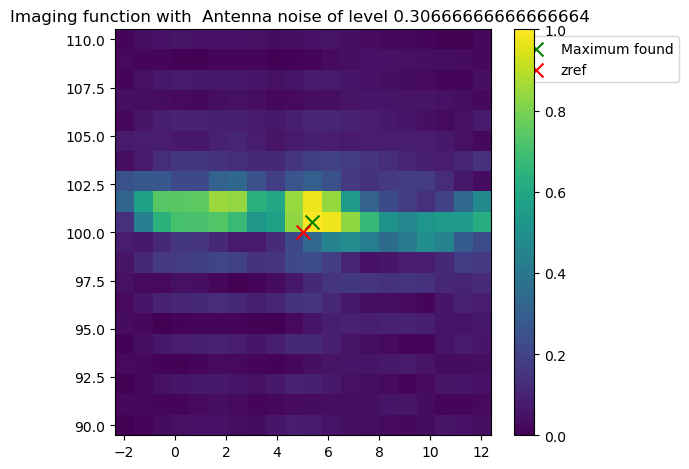

Difference between the ground truth and the maxima: 1.6213601895525667


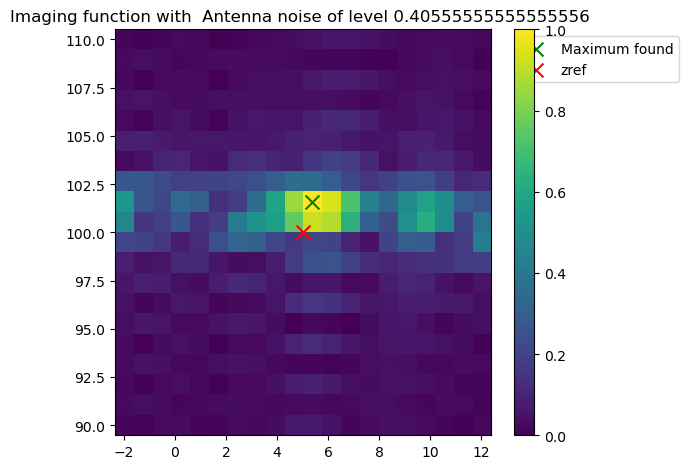

Difference between the ground truth and the maxima: 7.1758675288945915


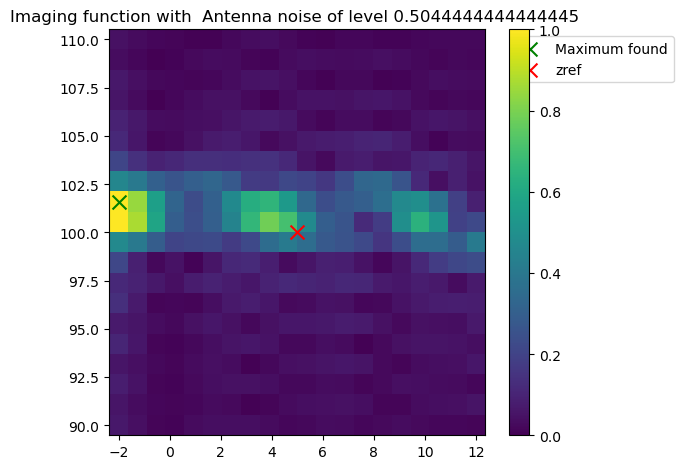

Difference between the ground truth and the maxima: 3.3573007229088554


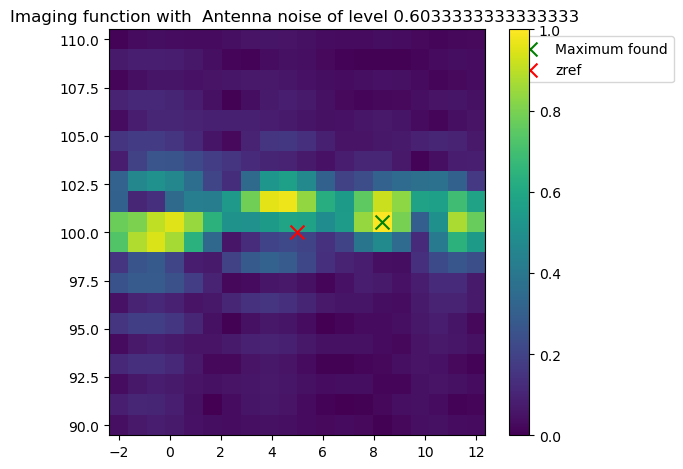

Difference between the ground truth and the maxima: 3.672537899877793


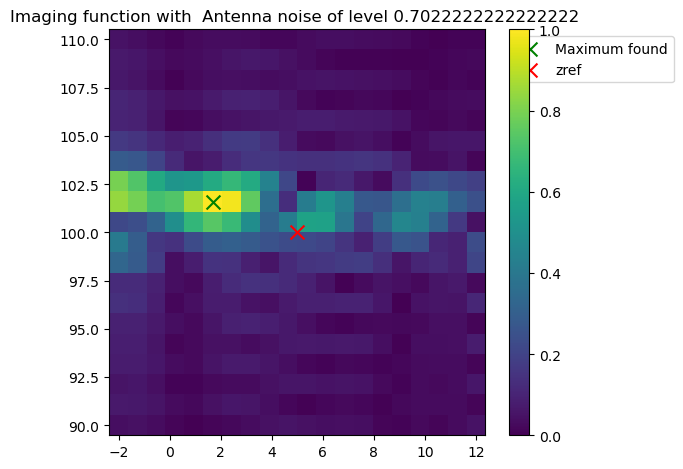

Difference between the ground truth and the maxima: 2.4261959098139187


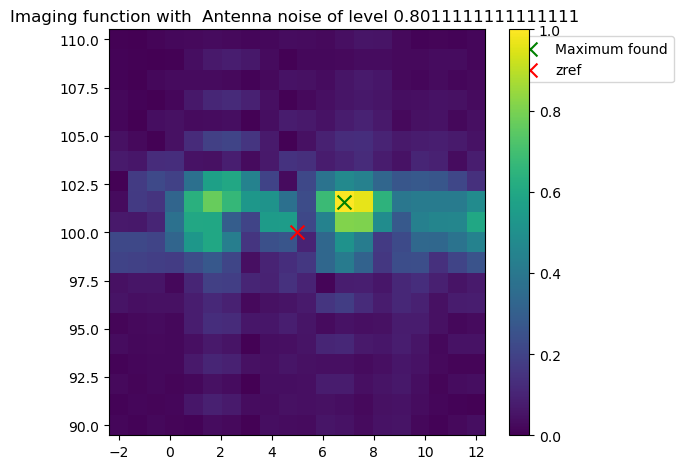

Difference between the ground truth and the maxima: 6.459119259361001


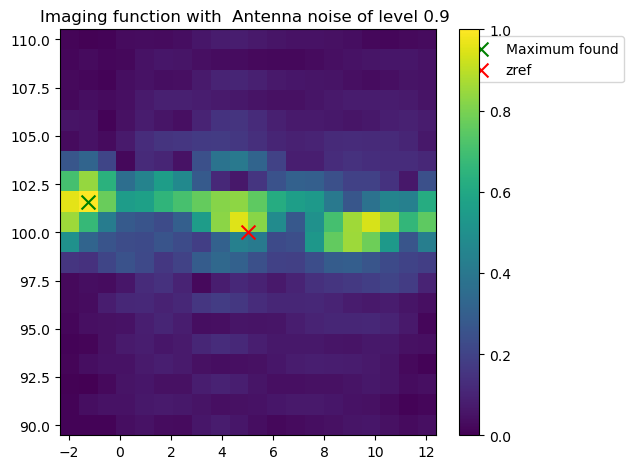

res []
res [0.6424502955649323]
res [0.6424502955649323, 0.5576215815899241]
res [0.6424502955649323, 0.5576215815899241, 1.8110158456931855]
res [0.6424502955649323, 0.5576215815899241, 1.8110158456931855, 1.9638350744005941]
res [0.6424502955649323, 0.5576215815899241, 1.8110158456931855, 1.9638350744005941, 1.1888796840080558]
res [0.6424502955649323, 0.5576215815899241, 1.8110158456931855, 1.9638350744005941, 1.1888796840080558, 3.2277364434656746]
res [0.6424502955649323, 0.5576215815899241, 1.8110158456931855, 1.9638350744005941, 1.1888796840080558, 3.2277364434656746, 1.7394318810169205]
res [0.6424502955649323, 0.5576215815899241, 1.8110158456931855, 1.9638350744005941, 1.1888796840080558, 3.2277364434656746, 1.7394318810169205, 3.396776213214416]
res [0.6424502955649323, 0.5576215815899241, 1.8110158456931855, 1.9638350744005941, 1.1888796840080558, 3.2277364434656746, 1.7394318810169205, 3.396776213214416, 1.2849005911298645]
res []
res [0.36842105263157876]
res [0.3684210526

C:\Users\lix\AppData\Local\Temp\ipykernel_21748\2031496696.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\lix\AppData\Local\Temp\ipykernel_21748\2031496696.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


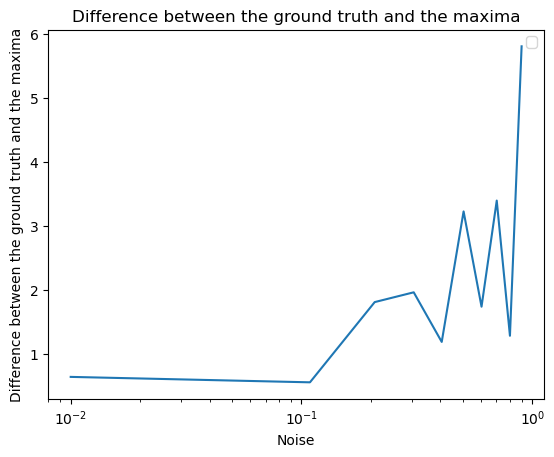

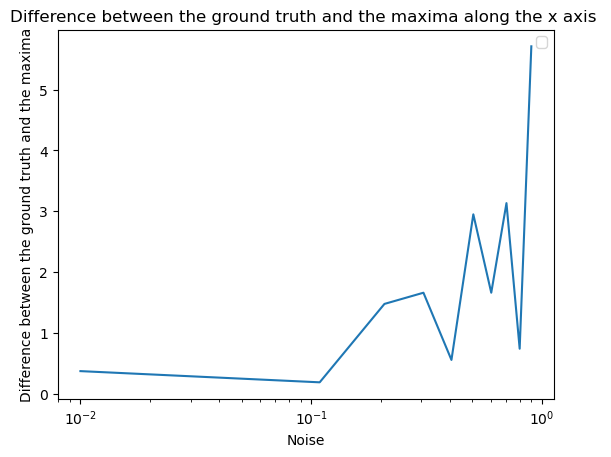

res []
res [0.526315789473685]
res [0.526315789473685, 0.526315789473685]
res [0.526315789473685, 0.526315789473685, 1.05263157894737]
res [0.526315789473685, 0.526315789473685, 1.05263157894737, 1.05263157894737]
res [0.526315789473685, 0.526315789473685, 1.05263157894737, 1.05263157894737, 1.05263157894737]
res [0.526315789473685, 0.526315789473685, 1.05263157894737, 1.05263157894737, 1.05263157894737, 1.3157894736842053]
res [0.526315789473685, 0.526315789473685, 1.05263157894737, 1.05263157894737, 1.05263157894737, 1.3157894736842053, 0.526315789473685]
res [0.526315789473685, 0.526315789473685, 1.05263157894737, 1.05263157894737, 1.05263157894737, 1.3157894736842053, 0.526315789473685, 1.3157894736842053]
res [0.526315789473685, 0.526315789473685, 1.05263157894737, 1.05263157894737, 1.05263157894737, 1.3157894736842053, 0.526315789473685, 1.3157894736842053, 1.05263157894737]


C:\Users\lix\AppData\Local\Temp\ipykernel_21748\2031496696.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


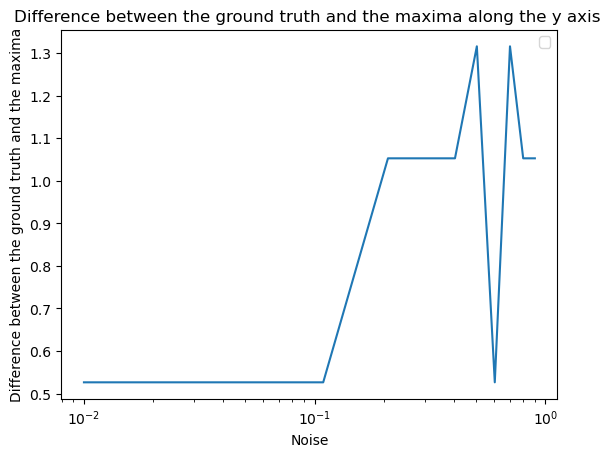

In [ ]:
x = np.meshgrid(np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res))
noisel = np.linspace(0.01, 0.9, 10)
compute_noise_postion(noisel)

Un phénomène intéressant est observé : l'erreur de déplacement du maximum est principalement visible sur l'axe \(x\), tandis qu'elle reste plus limitée sur l'axe \(y\).  

Avec l'augmentation du bruit, l'erreur sur l'axe \(x\) croît de manière significative. En revanche, sur l'axe \(y\), l'erreur évolue plus graduellement avant de présenter des variations plus marquées, ce qui s'explique par un déplacement plus faible dans cette direction.  

Ces observations sont en accord avec l'analyse visuelle.

